In [47]:
%matplotlib inline
import loompy
import logging
import pandas as pd
import numpy as np
import cytograph as cg
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import *
from sklearn.metrics.pairwise import cosine_distances
import numpy_groupies as npg
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sparse
import networkx as nx
import community
from sklearn.manifold import TSNE
from matplotlib.collections import LineCollection


In [2]:
f = "/Users/stelin/build_20171205/L6_R3_(Astroependymal cells).loom"

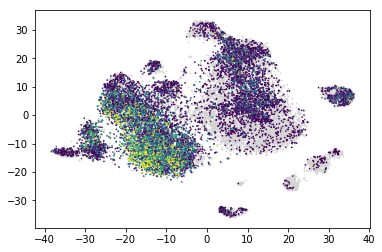

In [3]:
with loompy.connect(f) as ds:
    gene = "Mfge8"
    plt.scatter(ds.ca._X,ds.ca._Y,s=10,lw=0,marker='.',c="lightgrey")
    cells = ds[ds.ra.Gene == gene, :][0] > 0
    color = ds[ds.ra.Gene == gene, :][0][cells]
    plt.scatter(ds.ca._X[cells],ds.ca._Y[cells],s=10,lw=0,vmax=np.percentile(color, 95),marker='.',c=color)


In [6]:
with loompy.connect(f) as ds:
    genes = cg.FeatureSelection(n_genes=5000).fit(ds)
    m = ds.sparse(genes)

In [7]:
hpf=cg.HPF(k=50,a=1,b=3,c=1,d=3)
hpf.fit(m.transpose())

2018-04-28 22:42:07,171 INFO: Iteration 20, ll = -17537137, diff = 0.070627
2018-04-28 22:47:30,391 INFO: Iteration 30, ll = -16904968, diff = 0.036047
2018-04-28 22:53:19,529 INFO: Iteration 40, ll = -16609786, diff = 0.017461
2018-04-28 22:59:08,501 INFO: Iteration 50, ll = -16478723, diff = 0.007891
2018-04-28 23:05:28,128 INFO: Iteration 60, ll = -16426120, diff = 0.003192
2018-04-28 23:11:18,587 INFO: Iteration 70, ll = -16407500, diff = 0.001134
2018-04-28 23:17:10,364 INFO: Iteration 80, ll = -16401824, diff = 0.000346
2018-04-28 23:22:41,653 INFO: Iteration 90, ll = -16399330, diff = 0.000152
2018-04-28 23:28:41,785 INFO: Iteration 100, ll = -16399637, diff = 0.000019
2018-04-28 23:34:27,334 INFO: Iteration 110, ll = -16400791, diff = 0.000070
2018-04-28 23:40:19,829 INFO: Iteration 120, ll = -16402342, diff = 0.000095
2018-04-28 23:46:13,696 INFO: Iteration 130, ll = -16404089, diff = 0.000107
2018-04-28 23:52:23,264 INFO: Iteration 140, ll = -16406161, diff = 0.000126
2018-04

In [19]:
hpf.beta[:,6].max()

6.2851315814949259e-226

In [22]:
with loompy.connect(f) as ds:
    genes = ds.ra.Gene[:np.unique(ds.ca.Clusters).shape[0] * 10]
    data = ds[:np.unique(ds.ca.Clusters).shape[0] * 10, :]
    labels = ds.ca.Clusters

In [19]:
data = -data
for ix in range(0, labels.max() + 1, 1):
    data[ix*10:(ix+4)*10, labels == ix] = -data[ix*10:(ix+4)*10, labels == ix] + 0.01

In [67]:
N = data.shape[1]
d = []
j = 21141
for ix in range(N):
    d.append(cg.poisson_distance(data[:, j].astype("float64"), data[:, ix].astype("float64")))
d = np.array(d)

In [69]:
bnn = cg.BalancedKNN(k=20, maxl=40, sight_k=40, metric=cg.poisson_distance)
bnn.fit(data.T)
knn = bnn.kneighbors_graph(mode='connectivity')

2018-04-24 16:24:26,123 DEBUG: First search the 40 nearest neighbours for 22286


KeyboardInterrupt: 

36


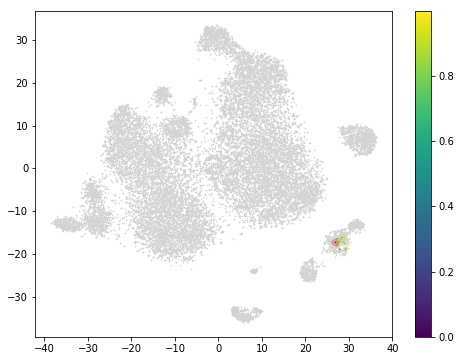

In [68]:
with loompy.connect(f) as ds:
    #print(np.where(ds[ds.ra.Gene=="Pdgfra", :]>0))
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    plt.scatter(ds.ca._X,ds.ca._Y,s=10,lw=0,marker='.',c="lightgrey")
    cells = d < 1
    cax=plt.scatter(ds.ca._X[:N][cells],ds.ca._Y[:N][cells],s=10,vmin=0,cmap="viridis",lw=0,marker='.',c=d[cells])
    plt.scatter(ds.ca._X[j],ds.ca._Y[j],s=40,c="red",alpha=0.25)
    plt.colorbar(cax)
    print(cells.sum())

In [69]:
%%time
STEP = 1
d = data[:, ::STEP].transpose()
am = cg.AbsoluteManifold(radius=1.5)
am.fit(d)

/Users/sten/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


CPU times: user 35min 27s, sys: 5.13 s, total: 35min 32s
Wall time: 35min 37s


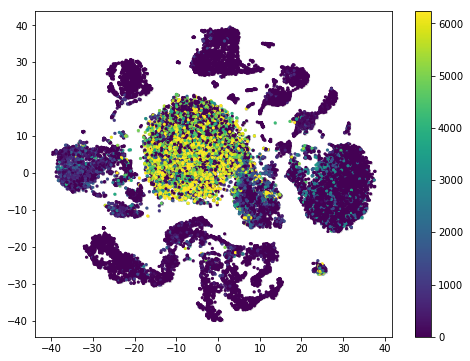

In [70]:
N = d.shape[0]
with loompy.connect(f) as ds:
    plt.figure(figsize=(8,6))
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,vmin=0,vmax=np.percentile(am.n_neighbors, 95),cmap="viridis",lw=0,marker='.',c=am.n_neighbors)
    plt.colorbar(cax)

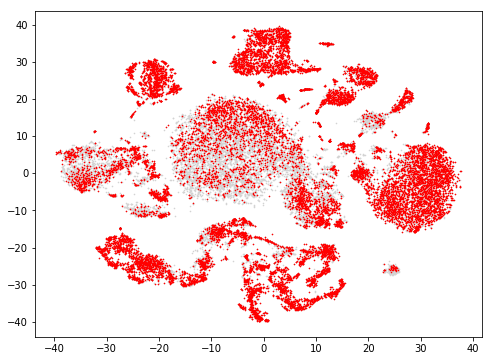

In [71]:
with loompy.connect(f) as ds:
    #print(np.where(ds[ds.ra.Gene=="Pdgfra", :]>0))
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    sample = am.outliers()
    plt.scatter(ds.ca._X[::STEP][sample],ds.ca._Y[::STEP][sample],s=10,vmin=0,cmap="viridis",lw=0,marker='.',c='red')

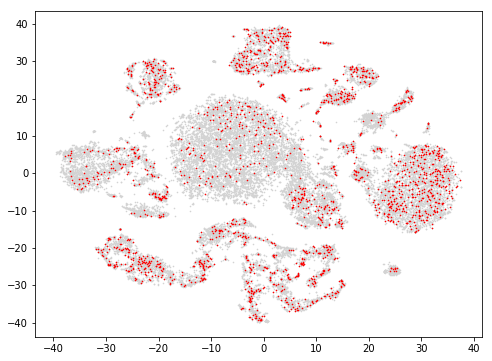

In [73]:
with loompy.connect(f) as ds:
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    sample = am.sample(N=2000, pseudocounts=10)
    plt.scatter(ds.ca._X[::STEP][sample],ds.ca._Y[::STEP][sample],s=10,vmin=0,cmap="viridis",lw=0,marker='.',c='red')

In [75]:
smoothened = am.smoothen(normalize=True)

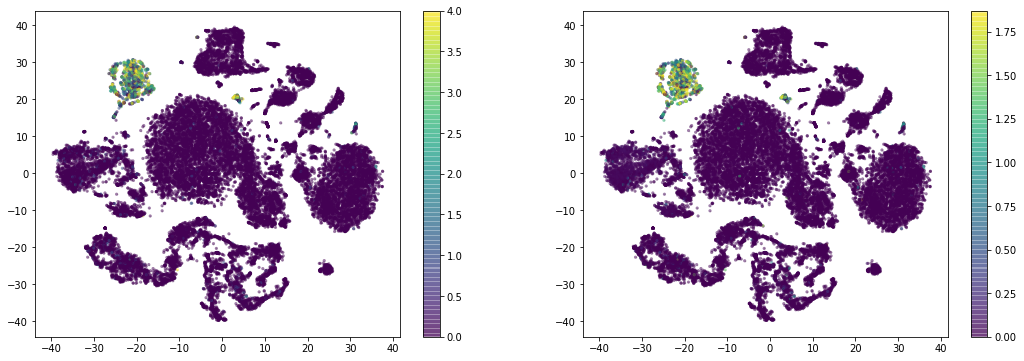

In [165]:
gene = "Aif1"
with loompy.connect(f) as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,alpha=0.5,vmin=0,vmax=np.percentile(am.data[:,gix],99),cmap="viridis",lw=0,marker='.',
                    c=am.data[:,gix])
    plt.colorbar(cax)
    
    plt.subplot(1,2,2)
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,alpha=0.5,vmin=0,vmax=np.percentile(smoothened[:,gix],99),cmap="viridis",lw=0,marker='.',
                    c=smoothened[:,gix])
    plt.colorbar(cax)

In [166]:
#selected = np.sort(am.sample(N=7000))
xy = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      n_components=2,
                      metric=cg.poisson_distance).fit_transform(data.T)

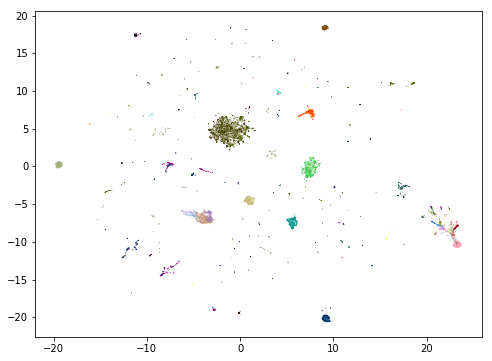

In [172]:
with loompy.connect(f) as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(8,6))
    cax=plt.scatter(xy[:,0],xy[:,1],s=1,alpha=1,vmin=0,lw=0,marker='.',
                    c=cg.colorize(ds.ca.Clusters))
    #plt.colorbar(cax)
    #plt.ylim((-8,3))
    #plt.xlim((-15,10))

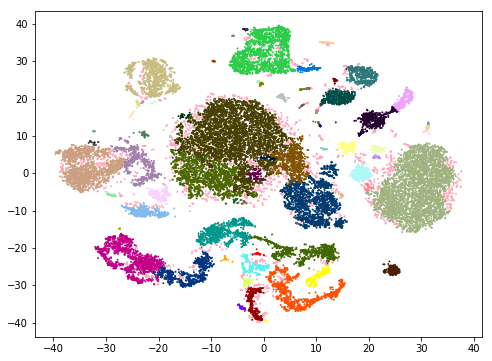

In [168]:
with loompy.connect(f) as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(8,6))
#    plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,lw=0,marker='.', c="lightgrey")
    #cells = smoothened[:,gix] > 0
    cax=plt.scatter(ds.ca._X,ds.ca._Y,s=15,alpha=1,vmin=0,lw=0,marker='.',
                    c=cg.colorize(ds.ca.Clusters))

In [ ]:
plt.figure(figsize=(8,6))
cax=plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,vmin=0,vmax=8000,cmap="viridis",lw=0,marker='.',c=am.n_neighbors[selected])
plt.colorbar(cax)

In [ ]:
plt.figure(figsize=(8,6))
cax=plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,vmin=0,vmax=6000,cmap="viridis",lw=0,marker='.',c=am.data.sum(axis=1)[selected])
plt.colorbar(cax)

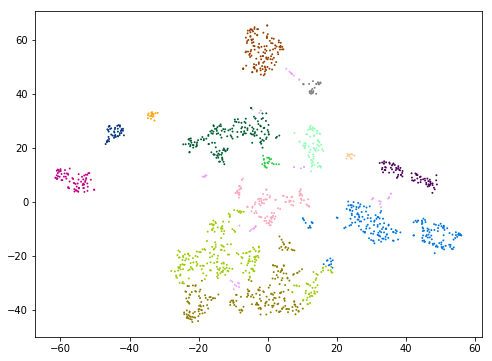

In [22]:
f = "/Users/stelin/build_20171205/L1_Sympathetic.loom"
with loompy.connect(f) as ds:
    plt.figure(figsize=(8,6))
    plt.scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1],s=15,alpha=1,vmin=0,lw=0,marker='.',c=cg.colorize(ds.ca.Clusters))

In [81]:
f = "/Users/stelin/build_20171205/L1_Cortex1.loom"
with loompy.connect(f) as ds:
    n_clusters = ds.ca.Clusters.max() + 1
    data = ds[:n_clusters*10, :].transpose()

In [84]:
am = cg.AbsoluteManifold(radius=1)
am.fit(data)

KeyboardInterrupt: 

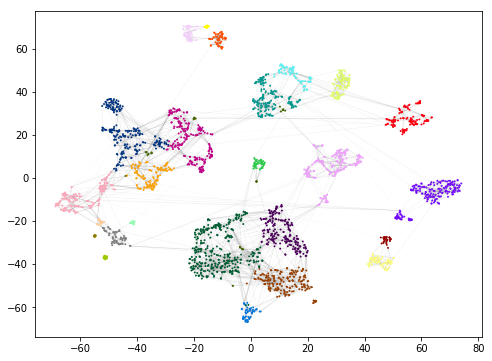

In [80]:
f = "/Users/stelin/build_20171205/L1_DRG.loom"
with loompy.connect(f) as ds:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    cax=plt.scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1],s=15,alpha=1,vmin=0,lw=0,marker='.',c=cg.colorize(ds.ca.Clusters))
    #plt.colorbar(cax)
    g = ds.col_graphs.KNNP
    (a, b, w) = (g.row, g.col, g.data)
    pos = ds.ca.TSNE
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, zorder=0, color='grey', alpha=0.1)
    ax.add_collection(lc)
